In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data  = pd.read_csv('MSFT_Stock.csv', index_col='Date', parse_dates=['Date'])

## Check data

In [3]:
print(data.info())
print('*'*50)
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB
None
**************************************************
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

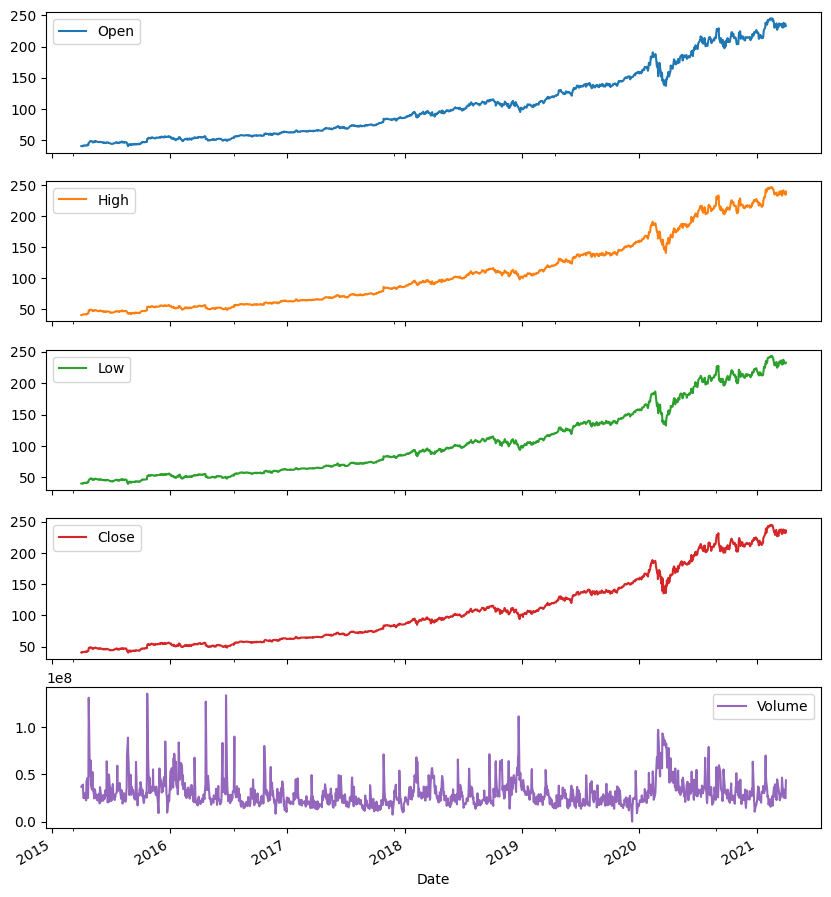

In [4]:
data['2015':'2021'].plot(subplots=True, figsize=(10,12))

<Axes: xlabel='Date'>

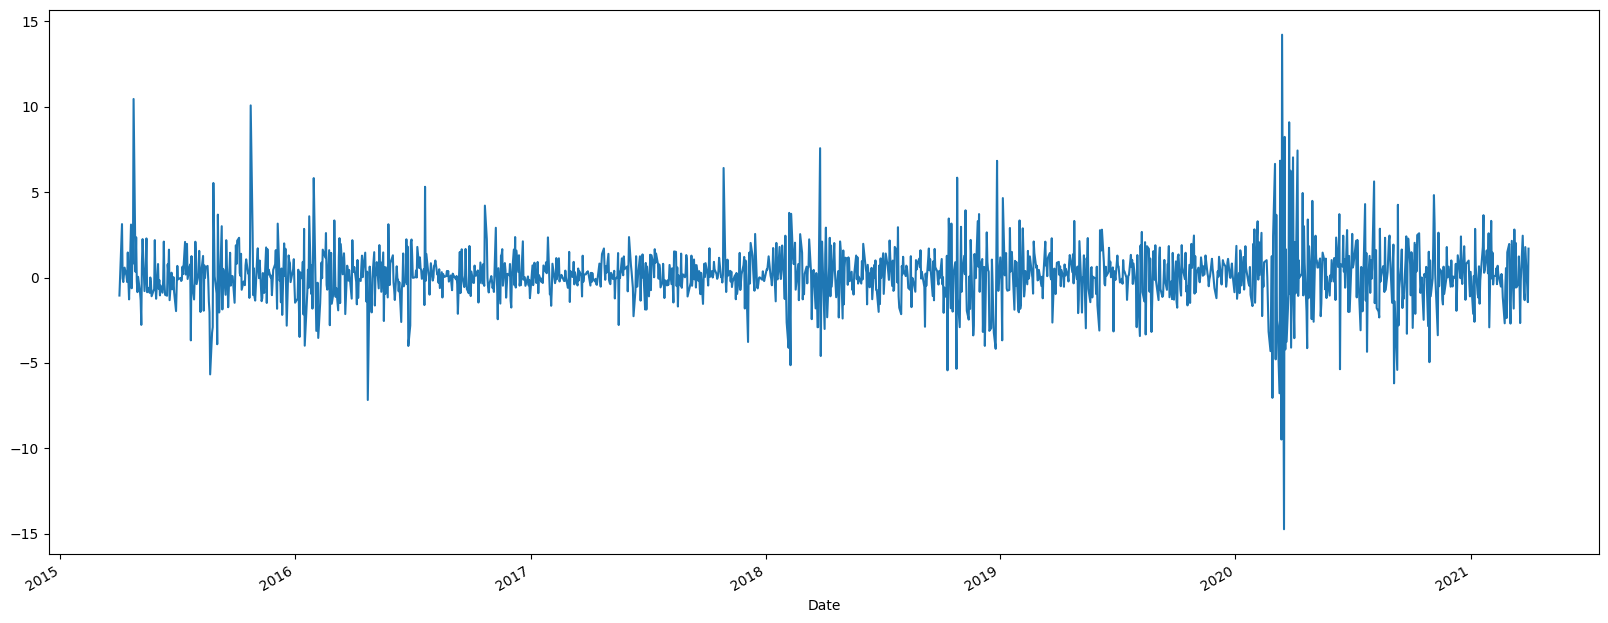

In [5]:
data['return'] = data.Close.pct_change()*100
data['return'].plot(figsize=(20,8))

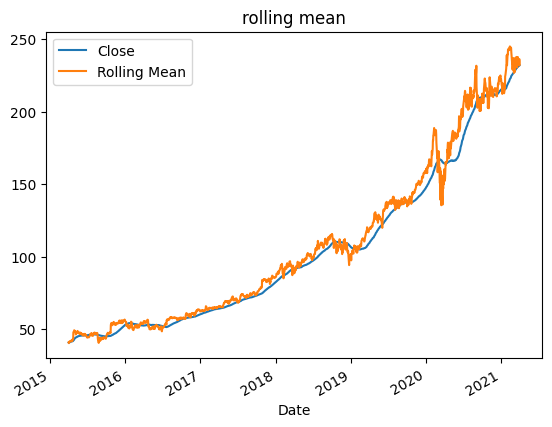

In [6]:
y = data['Close'].rolling(window='90D').mean()
y.plot(title = 'rolling mean')
data.Close.plot()
plt.legend(['Close','Rolling Mean'])

Text(0.5, 1.0, 'Partial Autocorrelation Function')

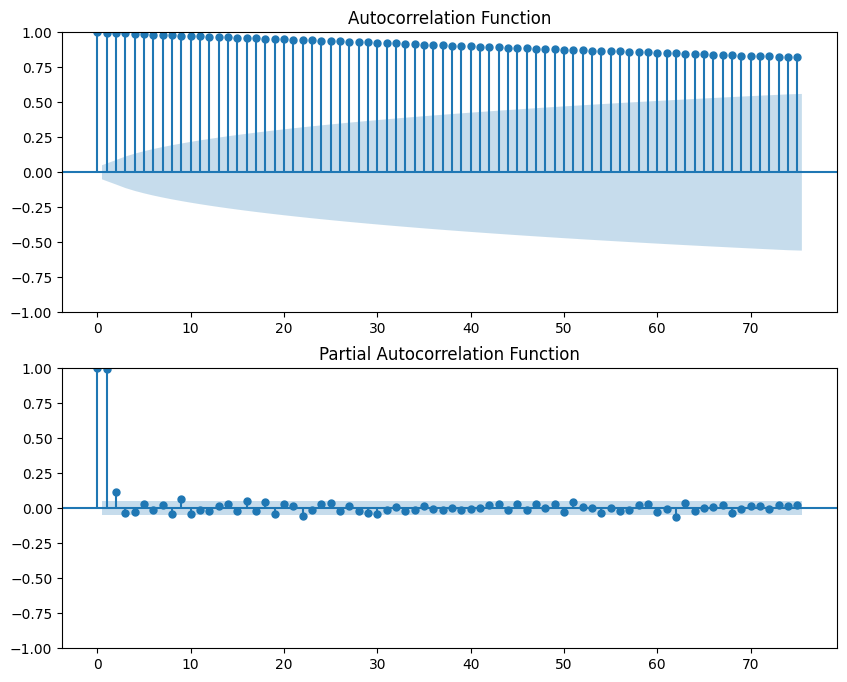

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data["Close"],ax=ax1,lags=75)
ax1.set_title('Autocorrelation Function')
plot_pacf(data["Close"], ax=ax2, lags=75)
ax2.set_title('Partial Autocorrelation Function')

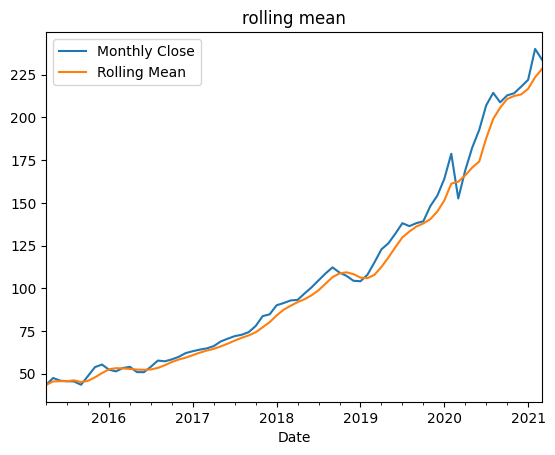

In [8]:
data.index=pd.to_datetime(data.index)
#data.set_index('dateIndex',inplace=True)
df = data['Close'].resample('MS').mean()
y2 = df.rolling(window='120D').mean()
df.plot()
y2.plot(title = 'rolling mean')
plt.legend(['Monthly Close','Rolling Mean'])

## Data Cleaning and Feature Analysis

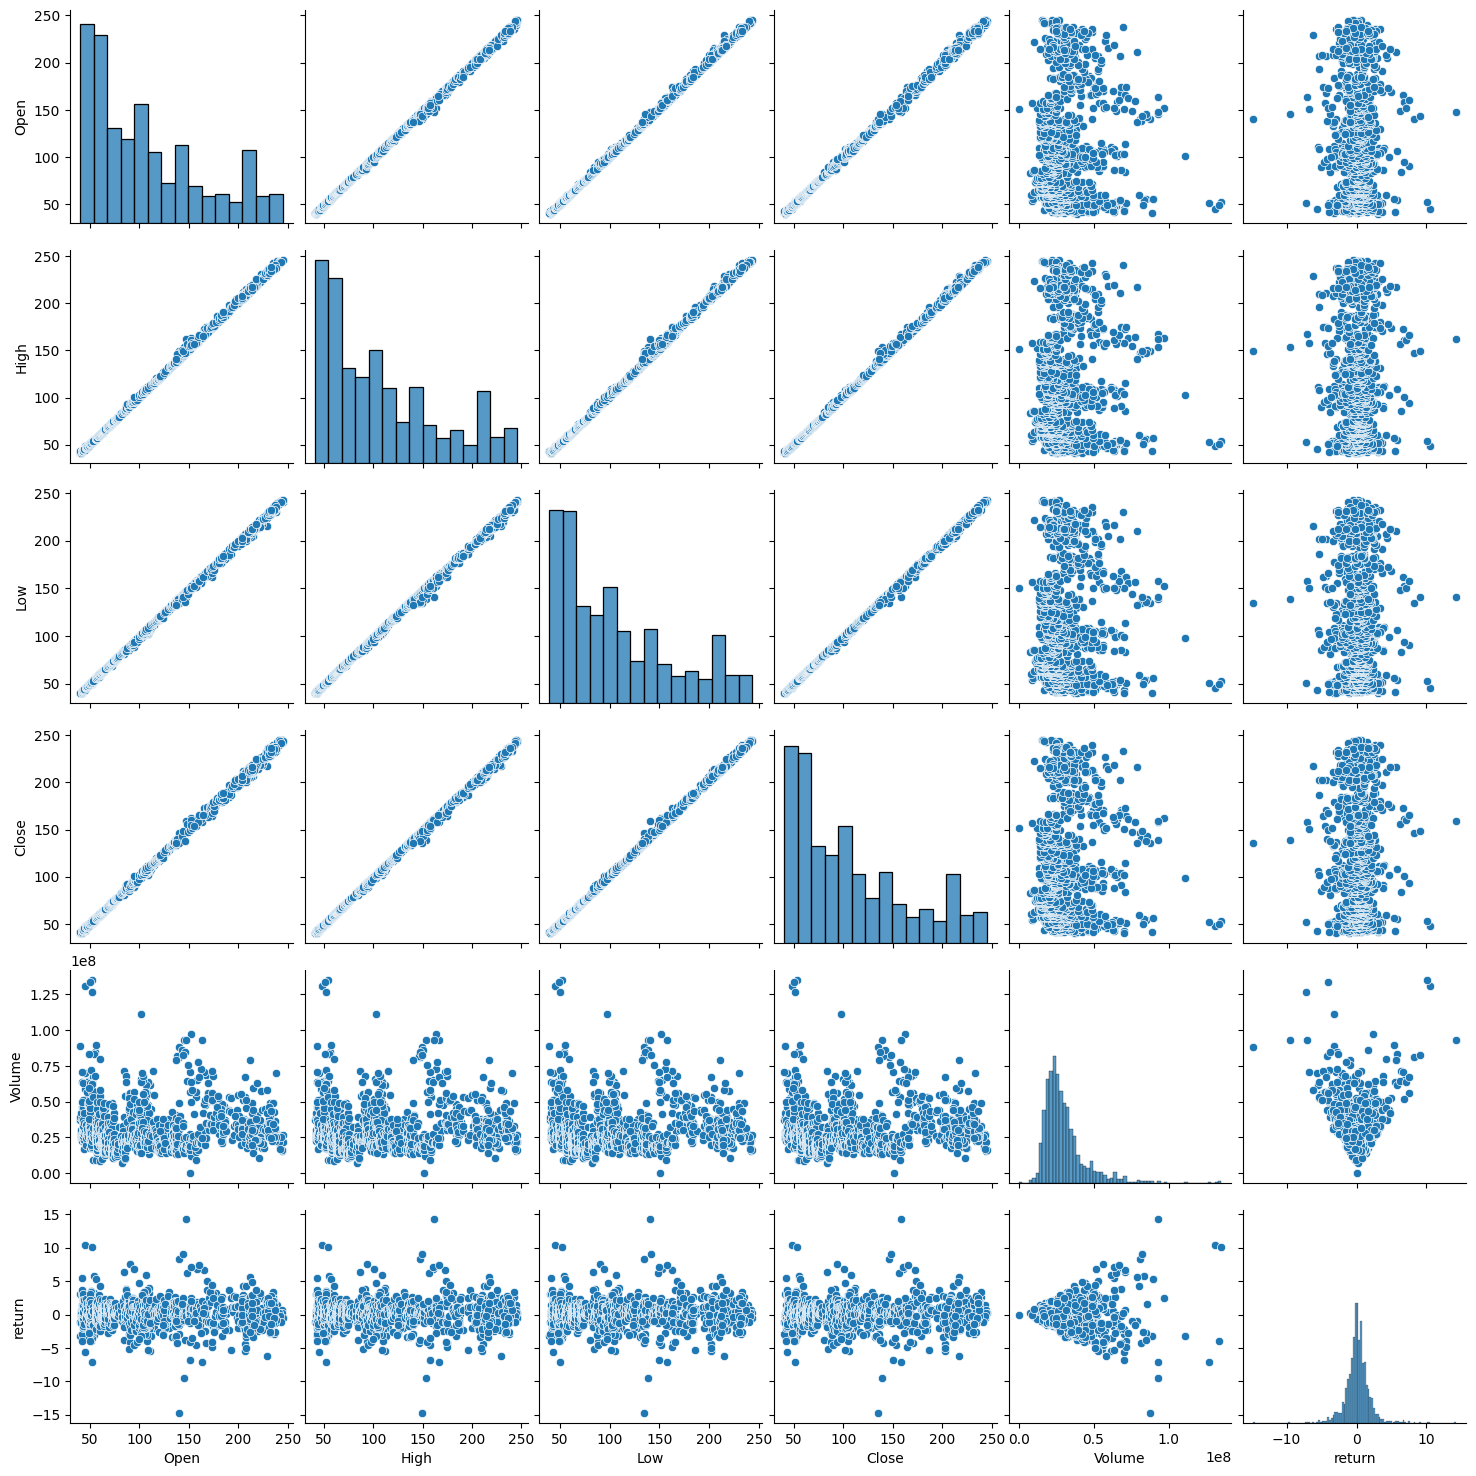

In [9]:
import seaborn as sns
sns.pairplot(data)

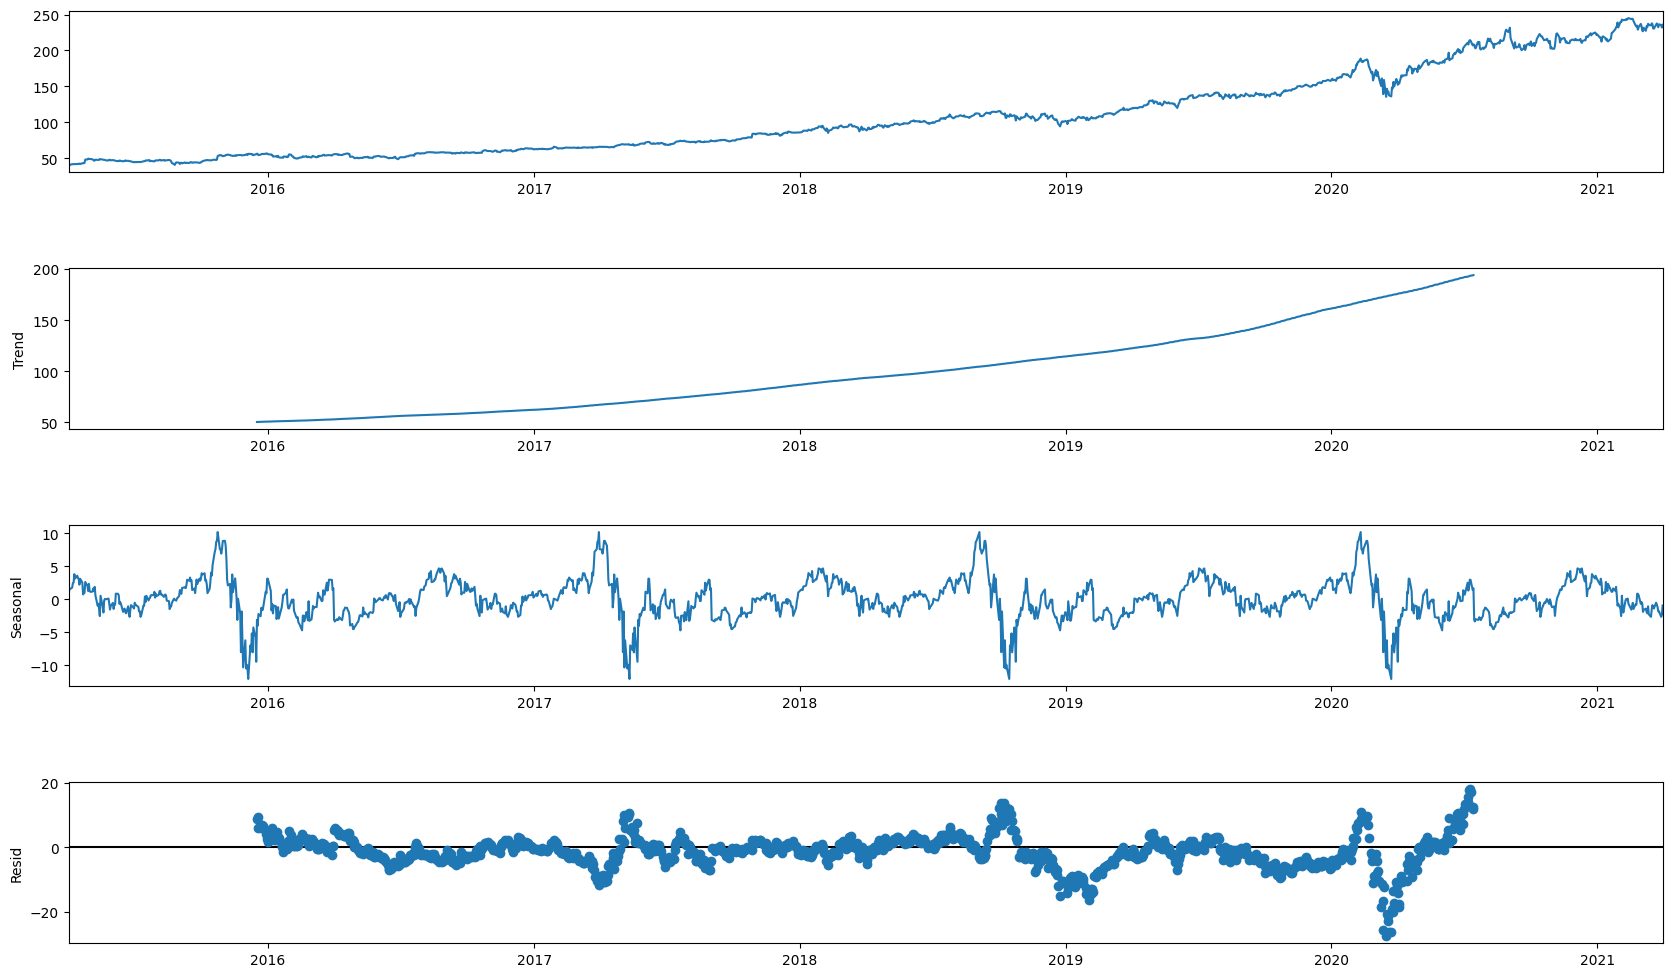

In [10]:
decomposed = sm.tsa.seasonal_decompose(data[['Close']], model='additive',period = 360)
fig = decomposed.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Model

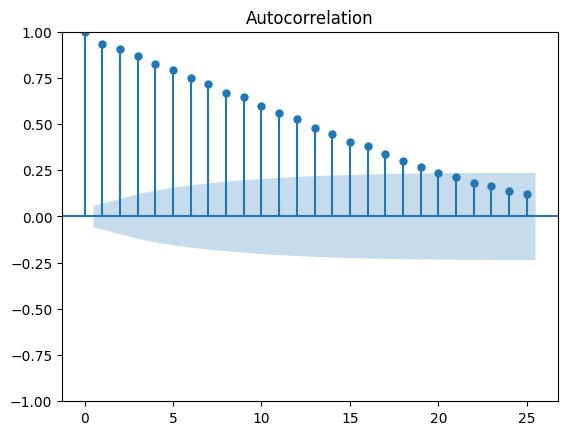

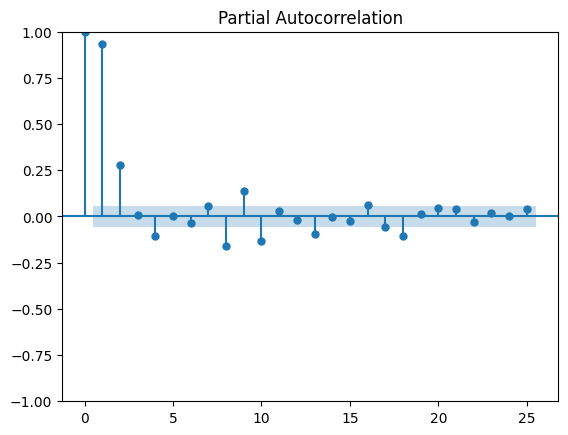

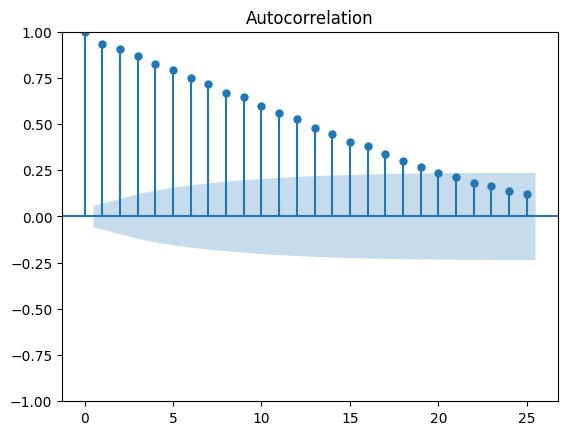

In [11]:
de = decomposed.resid.dropna()
plot_pacf(de, lags=25)
plot_acf(de, lags=25)

ADF Statistic: -2.707539
p-value: 0.072743
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


<Axes: xlabel='Date'>

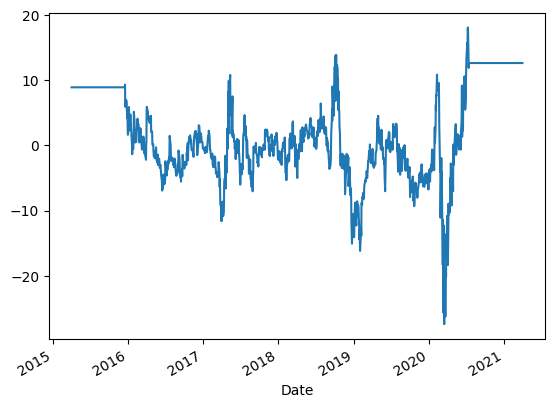

In [38]:
res = decomposed.resid.fillna(decomposed.resid.bfill())
res = res.fillna(res.ffill())
adf = adfuller(res)
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
	print('\t%s: %.3f' % (key, value))
res.plot()

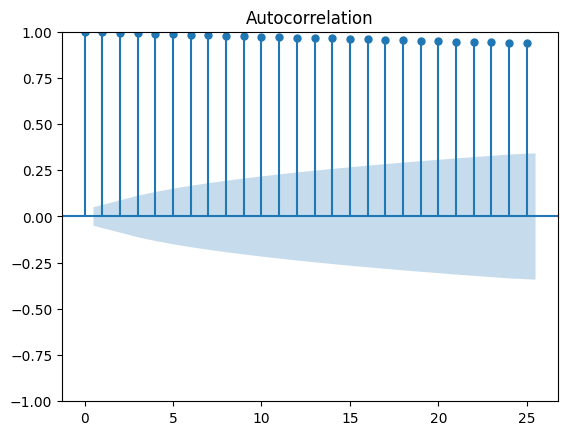

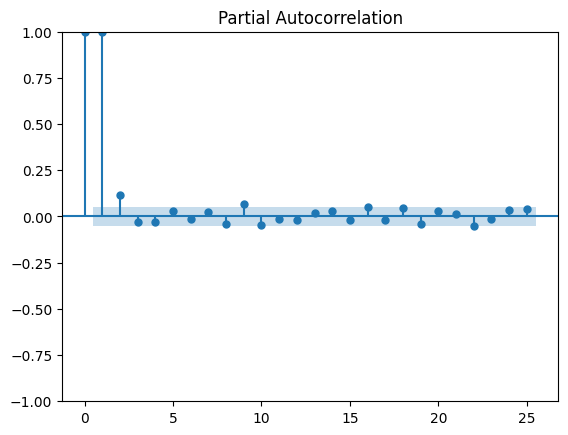

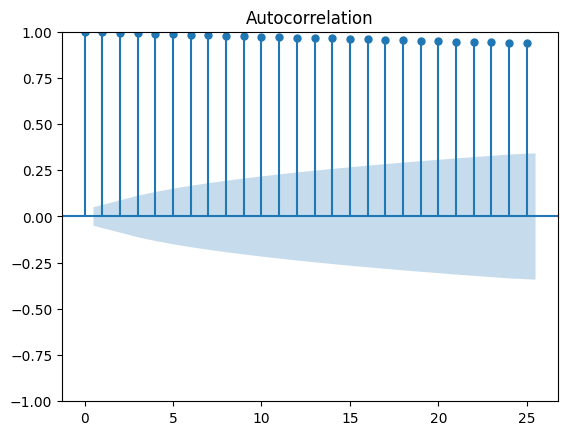

In [29]:
plot_pacf(data['Close'], lags=25)
plot_acf(data['Close'], lags=25)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80027D+00    |proj g|=  6.74056D-01

At iterate    5    f=  2.45572D+00    |proj g|=  2.57476D-02

At iterate   10    f=  2.44466D+00    |proj g|=  9.08242D-03

At iterate   15    f=  2.33251D+00    |proj g|=  1.91075D-01

At iterate   20    f=  2.26984D+00    |proj g|=  3.12692D-02

At iterate   25    f=  2.24818D+00    |proj g|=  7.72134D-02

At iterate   30    f=  2.24157D+00    |proj g|=  1.48958D-03

At iterate   35    f=  2.24156D+00    |proj g|=  4.20092D-05
  ys=-1.057E-05  -gs= 9.890E-07 BFGS update SKIPPED

At iterate   40    f=  2.24155D+00    |proj g|=  2.20315D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

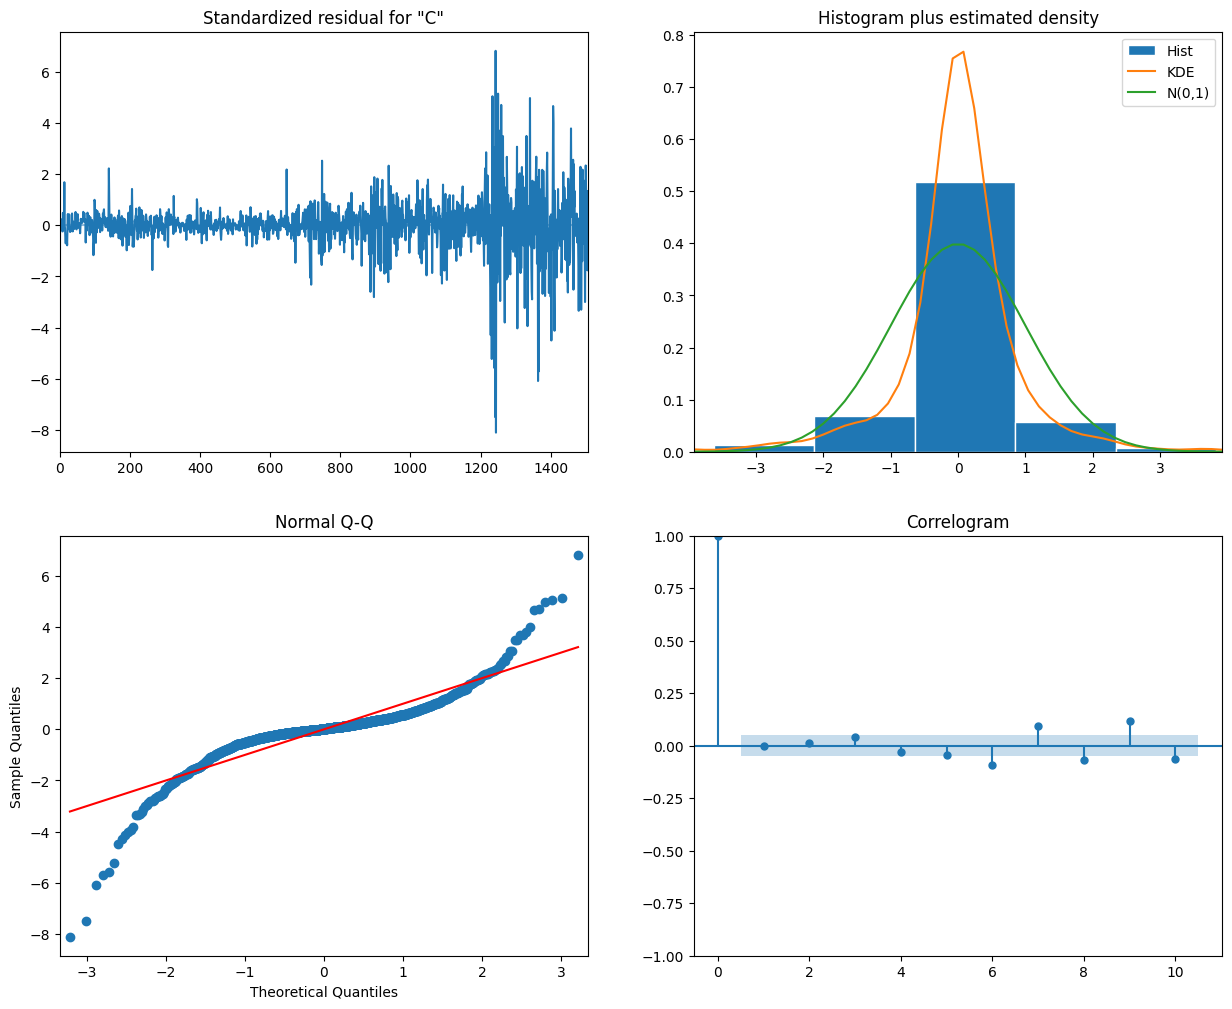

In [34]:
model = sm.tsa.statespace.SARIMAX(data['Close'],order=(2, 3, 2))
results = model.fit()
results.plot_diagnostics(figsize=(15, 12))
plt.show()

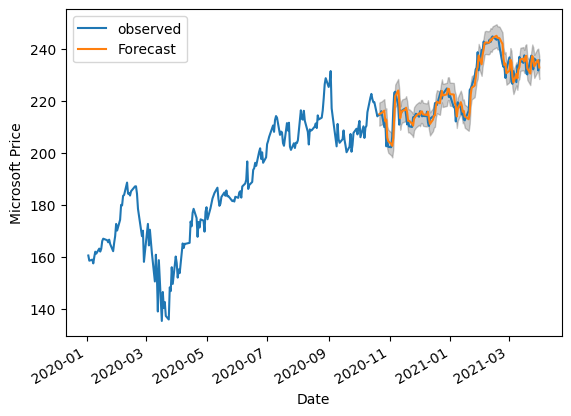

In [36]:
# Use real data
pred = results.get_prediction(start=1400, dynamic=False)
pred_ci = pred.conf_int()
ax = data['Close']['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Microsoft Price')
plt.legend()
plt.show()

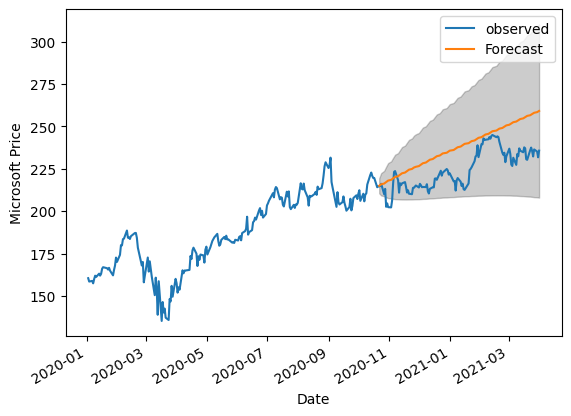

In [37]:
# Use predicted data
pred = results.get_prediction(start=1400, dynamic=True)
pred_ci = pred.conf_int()
ax = data['Close']['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Microsoft Price')
plt.legend()
plt.show()